# Self - Attention 모듈 구현

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd "/content/gdrive/MyDrive/Colab Notebooks/만들면서 배우는 파이토치 딥러닝/5.  GAN을 활용한 화상 생성/data"

/content/gdrive/MyDrive/Colab Notebooks/만들면서 배우는 파이토치 딥러닝/5.  GAN을 활용한 화상 생성/data


In [ ]:
import os
os.getcwd()

'/content/gdrive/MyDrive/Colab Notebooks/만들면서 배우는 파이토치 딥러닝/5.  GAN을 활용한 화상 생성/data'

In [66]:
# 패키지 import
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [67]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# Self - Attention 모듈 구현

In [68]:
# Self - Attention 모듈 구현(Attention Map도 함께 출력)
class Self_Attention(nn.Module):
  """Self-Attention 레이어"""

  def __init__(self, in_dim):
    super(Self_Attention, self).__init__()

    # 1x1의 합성곱 층을 활용한 점별 합성곱 준비
    self.query_conv = nn.Conv2d(
        in_channels = in_dim, out_channels = in_dim//8, kernel_size = 1
    )
    self.key_conv = nn.Conv2d(
        in_channels = in_dim, out_channels = in_dim//8, kernel_size = 1
    )
    self.value_conv = nn.Conv2d(
        in_channels = in_dim, out_channels = in_dim, kernel_size = 1
    )

    # Attention Map을 작성할 때 규격화 소프트맥스
    self.softmax = nn.Softmax(dim = -2)

    # 원래 입력 x와 Self-Attention Map인 o을 더할 때 계수
    # output = x + gamma * o
    # 처음에는 gamma = 0으로 학습
    self.gamma = nn.Parameter(torch.zeros(1))

  def forward(self, x):

    # 입력 변수
    X = x

    # 합성곱한 뒤, 크기를 변형시킨다. B, C', W, H -> B, C', N으로
    proj_query = self.query_conv(X).view(
        X.shape[0], -1, X.shape[2] * X.shape[3]) # 크기 : B, C', N
    proj_query = proj_query.permute(0, 2, 1) # 전치 조작
    proj_key = self.key_conv(X).view(
        X.shape[0], -1, X.shape[2] * X.shape[3] # 크기 : B, C', N
    )

    # 곱셈
    S = torch.bmm(proj_query, proj_key) # bmm은 배치별 행렬곱

    # 규격화
    attention_map_T = self.softmax(S) # i 행 방향의 합을 1로 하는 소프트 맥스 함수
    attention_map = attention_map_T.permute(0, 2, 1) # 전치

    # Self-Attention Map을 계산
    proj_value = self.value_conv(X).view(
        X.shape[0], -1, X.shape[2] * X.shape[3]) # 크기: B, C, N
    o = torch.bmm(proj_value, attention_map.permute(0, 2, 1)) # Attention Map을 전치하여 곱함

    # Self - Attention Map o의 텐서 크기를 X로 준비하여 출력으로 한다.
    o = o.view(X.shape[0], X.shape[1], X.shape[2], X.shape[3])
    out = x + self.gamma * o

    return out, attention_map
  

# 생성기 Generator 구현
- 전치 합성곱 층에 스펙트럴 정규화를 추가
- 마지막 레이어인 라스트 층에는 전치합성곱 층에는 추가 x
- 레이어 3과 레이어 4의 사이, 그리고 레이어 4와 라스트 사이 두 군데에 Self-Attention 모듈 추가

In [69]:
class Generator(nn.Module):

  def __init__(self, z_dim = 20, image_size = 64):
    super(Generator, self).__init__()

    self.layer1 = nn.Sequential(
        # Spectral Normalization을 추가
        nn.utils.spectral_norm(nn.ConvTranspose2d(z_dim, image_size * 8, kernel_size = 4, stride = 1)),
        nn.BatchNorm2d(image_size * 8),
        nn.ReLU(inplace = True)
    )

    self.layer2 = nn.Sequential(
        # Spectral Normalization을 추가
        nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 8, image_size * 4, kernel_size = 4, stride = 2, padding = 1)),
        nn.BatchNorm2d(image_size * 4),
        nn.ReLU(inplace = True)
    )

    self.layer3 = nn.Sequential(
        # 스펙트럴 정규화 추가
        nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 4, image_size * 2, kernel_size = 4, stride = 2, padding = 1)),
        nn.BatchNorm2d(image_size * 2),
        nn.ReLU(inplace = True)
    )

    # Self-Attention 층 추가
    self.self_attention1 = Self_Attention(in_dim = image_size * 2)

    self.layer4 = nn.Sequential(
        # 스펙트럴 정규화 추가
        nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 2, image_size, kernel_size = 4, stride = 2, padding = 1)),
        nn.BatchNorm2d(image_size),
        nn.ReLU(inplace = True)
    )

    # Self - Attention 층 추가
    self.self_attention2 = Self_Attention(in_dim = image_size)

    self.last = nn.Sequential(
        nn.ConvTranspose2d(image_size, 1, kernel_size = 4, stride = 2, padding = 1),
        nn.Tanh()
    )

  def forward(self, z):
    out = self.layer1(z)
    out = self.layer2(out)
    out = self.layer3(out)
    out, attention_map1 = self.self_attention1(out)
    out = self.layer4(out)
    out, attention_map2 = self.self_attention2(out)
    out = self.last(out)

    return out, attention_map1, attention_map2

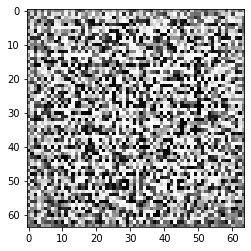

In [70]:
# 동작 확인
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim = 20, image_size = 64)

# 난수 입력
input_z = torch.randn(1, 20)

# 텐서 크기를 (1, 20, 1, 1)으로 변형
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# 가짜 화상을 출력
fake_images, attention_map1, attention_map2 = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

# 식별기 Discriminator 구현
- 합성곱 층에 스펙트럴 정규화를 추가함, 마지막 층에는 추가하지 않음
- 레이어 3과 레이어 4의 사이, 그리고 레이어 4와 라스트 사이의 두 군데에 Self-Attention 모듈을 추가함

In [71]:
class Discriminator(nn.Module):

  def __init__(self, z_dim = 20, image_size = 64):
    super(Discriminator, self).__init__()
    
    self.layer1 = nn.Sequential(
        # 스펙트럴 정규화 추가
        nn.utils.spectral_norm(nn.Conv2d(1, image_size, kernel_size = 4, stride = 2, padding = 1)),
        nn.LeakyReLU(0.1, inplace = True)
    )

    # 흑백 화상이므로 출력 채널은 하나

    self.layer2 = nn.Sequential(
        # 스펙트럴 정규화 추가
        nn.utils.spectral_norm(nn.Conv2d(image_size, image_size * 2, kernel_size = 4, stride = 2, padding = 1)),
        nn.LeakyReLU(0.1, inplace = True)
    )

    self.layer3 = nn.Sequential(
        # 스펙트럴 정규화 추가
        nn.utils.spectral_norm(nn.Conv2d(image_size * 2, image_size * 4, kernel_size = 4, stride = 2, padding = 1)),
        nn.LeakyReLU(0.1, inplace = True)
    )

    # Self - Attention 층 추가
    self.self_attention1 = Self_Attention(in_dim = image_size * 4)
    
    self.layer4 = nn.Sequential(
        # 스펙트럴 정규화 추가
        nn.utils.spectral_norm(nn.Conv2d(image_size * 4, image_size * 8, kernel_size = 4, stride = 2, padding = 1)),
        nn.LeakyReLU(0.1, inplace = True)
    )

    # Self-Attention 층 추가
    self.self_attention2 = Self_Attention(in_dim = image_size * 8)
    
    self.last = nn.Conv2d(image_size * 8, 1, kernel_size = 4, stride = 1)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out, attention_map1 = self.self_attention1(out)
    out = self.layer4(out)
    out, attention_map2 = self.self_attention2(out)
    out = self.last(out)

    return out, attention_map1, attention_map2



In [72]:
# 동작 확인
D = Discriminator(z_dim = 20, image_size = 64)

# 가짜 화상 생성
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images, _, _ = G(input_z)

# 가짜 화상을 D에 입력
d_out, attention_map1, attention_map2 = D(fake_images)

# 출력 d_out에 Sigmoid를 곱해 0에서 1로 변환
print(nn.Sigmoid()(d_out))

tensor([[[[0.5001]]]], grad_fn=<SigmoidBackward0>)


# Data Loader 작성

In [73]:
def make_datapath_list():
  """학습 및 검증 화상 데이터와 어노테이션 데이터의 파일 경로 리스트를 작성한다. """

  train_img_list = list() # 화상 파일 경로를 저장

  for img_idx in range(200):
    img_path = "./img_78/img_7_" + str(img_idx) + '.jpg'
    train_img_list.append(img_path)

    img_path = './img_78/img_8_' + str(img_idx) + '.jpg'
    train_img_list.append(img_path)

  return train_img_list


In [74]:
class ImageTransform():
  """화상의 전처리 클래스"""

  def __init__(self, mean, std):
    self.data_transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize(mean, std)
    ])

  def __call__(self, img):
    return self.data_transform(img)

In [75]:
class GAN_Img_Dataset(data.Dataset):
  """화상의 Dataset 클래스. PyTorch의 Dataset 클래스를 상속"""

  def __init__(self, file_list, transform):
    self.file_list = file_list
    self.transform = transform

  def __len__(self):
    '''화상 매수를 반환'''
    return len(self.file_list)

  def __getitem__(self, index):
    '''전처리한 화상의 Tensor 형식 데이터 취득'''

    img_path = self.file_list[index]
    img = Image.open(img_path) # [높이][폭]흑백

    # 화상 전처리
    img_transformed = self.transform(img)

    return img_transformed

In [76]:
# DataLoader 작성과 동작 확인

# 파일 리스트를 작성
train_img_list = make_datapath_list()

# Dataset 작성
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list = train_img_list, transform = ImageTransform(mean, std)
)

# DataLoader 작성
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True
)

# 동작 확인
batch_iterator = iter(train_dataloader) # 반복자로 변환
imges = next(batch_iterator) # 1 번째 요소를 꺼낸다
print(imges.size())

torch.Size([64, 1, 64, 64])


# 학습

In [77]:
# 모델을 학습시키는 함수를 작성
def train_model(G, D, dataloader, num_epochs):

    # GPU가 사용 가능한지 확인
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("사용 장치:", device)

    # 최적화 기법 설정
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 오차함수 정의 -> 적대적 손실 힌지 함수
    # criterion = nn.BCEWithLogitsLoss(reduction = 'mean)

    # 파라미터를 하드코딩
    z_dim = 20
    mini_batch_size = 64

    # 네트워크를 GPU로
    G.to(device)
    D.to(device)

    G.train() # 모델을 훈련 모드로
    D.train() # 모델을 훈련 모드로

    # 네트워크가 어느 정도 고정되면, 고속화 시킨다
    torch.backends.cudnn.benchmark = True

    # 화상의 매수
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # 반복 카운터 설정
    iteration = 1
    logs = []

    # epoch 루프
    for epoch in range(num_epochs):

      # 개시 시간을 저장
      t_epoch_start = time.time()
      epoch_g_loss = 0.0 # epoch의 손실합
      epoch_d_loss = 0.0 # epoch의 손실합

      print('----------------')
      print('Epoch {}/{}'.format(epoch, num_epochs))
      print('----------------')
      print('(train)')

      # 데이터 로더에서 mini batch씩 꺼내는 루프
      for imges in dataloader:

        # ----------------------
        # 1. Discriminator 학습
        # ----------------------
        # 미니 배치 크기가 1이면 배치 정규화에서 오류가 발생하므로 피한다.
        if imges.size()[0] == 1:
          continue

        # GPU를 사용할 수 있으면 GPU로 데이터를 보낸다.
        imges = imges.to(device)

        # 정답 라벨과 가짜 라벨 작성
        # 에폭의 마지막 반복은 미니 배치 수가 줄어든다.
        mini_batch_size = imges.size()[0]
        # label_real = torch.full((mini_batch_size, ), 1).to(device)
        # label_fake = torch.full((mini_batch_size, ), 0).to(device)

        # 진짜 화상 판정
        d_out_real, _, _ = D(imges)

        # 가짜 화상을 생성하여 판정
        input_z = torch.randn(mini_batch_size, z_dim).to(device)
        input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
        fake_images, _, _ = G(input_z)
        d_out_fake, _, _ = D(fake_images)

        # 오차 계산 -> 적대적 손실의 힌지 버전으로 변경
        # d_loss_real = criterion(d_out_real.view(-1), label_real)
        # d_loss_fake = criterion(d_out_fake.view(-1), label_fake)

        d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()
        # 오차 d_out_real이 1 이상에서 오차 0이 된다. d_out_real > 1 에서
        # 1.0 - d_out_real이 음수이면 ReLU로 0으로 한다.

        d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()
        # 오차 d_out_fake가 -1 이하이면 오차 0이 된다. d_out_fake < -1에서
        # 1.0 + d_out_real이 음수이면 ReLU로 0으로 한다.

        d_loss = d_loss_real + d_loss_fake

        # 역전파
        g_optimizer.zero_grad()
        d_optimizer.zero_grad()

        d_loss.backward()
        d_optimizer.step()

        # ------------------
        # 2. Generator 학습
        # ------------------
        # 가짜 화상을 생성하여 판정
        input_z = torch.randn(mini_batch_size, z_dim).to(device)
        input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
        fake_images, _, _ = G(input_z)
        d_out_fake, _, _ = D(fake_images)

        # 오차 계산 -> 적대적 손실의 힌지 버전으로 변경
        # g_loss = criterion(d_out_fake.view(-1), label_real)
        g_loss = - d_out_fake.mean()

        # 역전파
        g_optimizer.zero_grad()
        d_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # ------------------
        # 3. 기록
        # ------------------
        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()
        iteration += 1
  

      # 에폭의 phase별 손실과 정답률
      t_epoch_finish = time.time()
      print('------------------')
      print('epoch {} || Epoch_D_Loss:{:.4f} || Epoch_G_Loss:{:.4f}'.format(
          epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size
      )) 
      print('timer: {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
      t_epoch_start = time.time()

    # print("총 반복 횟수: ", iteration)

    return G,D

In [78]:
# 네트워크 초기화
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
      # Conv2d와 ConvTranspose2d 초기화
      nn.init.normal_(m.weight.data, 0.0, 0.02)
      nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
      # BatchNorm2d 초기화
      nn.init.normal_(m.weight.data, 1.0, 0.02)
      nn.init.constant_(m.bias.data, 0)

 # 초기화 실시
G.apply(weights_init)
D.apply(weights_init)
print("네트워크 초기화 완료")



네트워크 초기화 완료


In [79]:
# 학습 및 검증 실행
# 15분 정도 걸림
num_epochs = 300
G_update, D_update = train_model(
    G, D, dataloader = train_dataloader, num_epochs = num_epochs
)

사용 장치: cuda:0
----------------
Epoch 0/300
----------------
(train)
------------------
epoch 0 || Epoch_D_Loss:0.1578 || Epoch_G_Loss:0.0187
timer: 1.6515 sec.
----------------
Epoch 1/300
----------------
(train)
------------------
epoch 1 || Epoch_D_Loss:0.1226 || Epoch_G_Loss:0.0728
timer: 1.5950 sec.
----------------
Epoch 2/300
----------------
(train)
------------------
epoch 2 || Epoch_D_Loss:0.1206 || Epoch_G_Loss:0.0365
timer: 1.6068 sec.
----------------
Epoch 3/300
----------------
(train)
------------------
epoch 3 || Epoch_D_Loss:0.1202 || Epoch_G_Loss:-0.0022
timer: 1.5989 sec.
----------------
Epoch 4/300
----------------
(train)
------------------
epoch 4 || Epoch_D_Loss:0.1212 || Epoch_G_Loss:0.0856
timer: 1.5858 sec.
----------------
Epoch 5/300
----------------
(train)
------------------
epoch 5 || Epoch_D_Loss:0.1277 || Epoch_G_Loss:0.0093
timer: 1.5917 sec.
----------------
Epoch 6/300
----------------
(train)
------------------
epoch 6 || Epoch_D_Loss:0.0126 || Ep

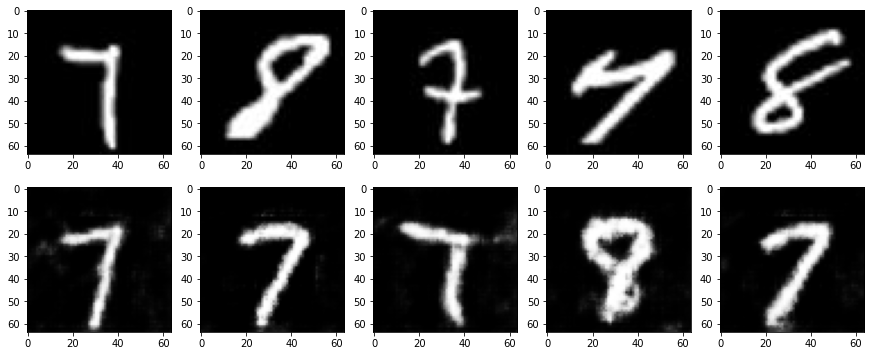

In [80]:
# 생성 화상과 훈련 데이터 시각화
# 이 셀은 괜찮은 느낌의 화상이 생성될 때까지 몇 번 재실행한다
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 입력 난수 생성
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 화상 생성
G_update.eval()
fake_images, am1, am2 = G_update(fixed_z.to(device))

# 훈련 데이터
batch_iterator = iter(train_dataloader) # 반복자로 변환
imges = next(batch_iterator) # 1 번째 요소를 꺼낸다

# 출력
fig = plt.figure(figsize = (15, 6))
for i in range(0, 5):
  # 상단에 훈련 데이터를,
  plt.subplot(2, 5, i + 1)
  plt.imshow(imges[i][0].cpu().detach().numpy()
  , 'gray')

  # 하단에 생성 데이터를 표시한다
  plt.subplot(2, 5, 5 + i + 1)
  plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

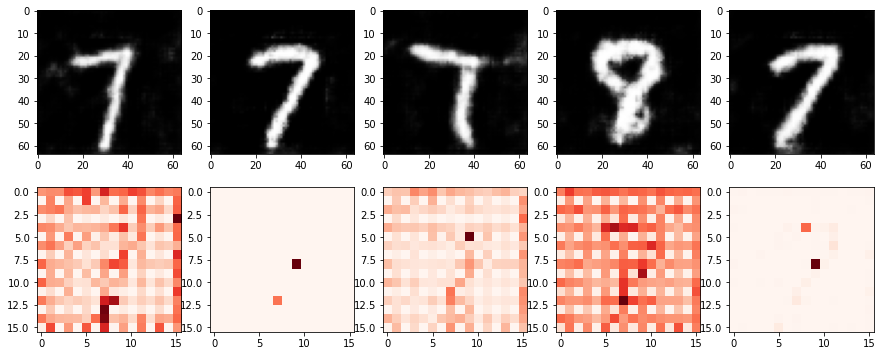

In [81]:
# Attention Map을 출력
fig = plt.figure(figsize = (15, 6))
for i in range(0, 5):

  # 상단에 생성한 화상 데이터를 표시
  plt.subplot(2, 5, i + 1)
  plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

  # 하단에 Attention Map1 화상 중앙의 픽셀 데이터를 표시
  plt.subplot(2, 5, 5 + i + 1)
  am = am1[i].view(16, 16, 16, 16)
  am = am[7][7] # 중앙에 주목
  plt.imshow(am.cpu().detach().numpy(), 'Reds')